In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from models.model_fpgan import FPGANSynthesizer

import ctgan
from sklearn.model_selection import train_test_split
from utils.privacy import normalized_avg_dist
from utils.fidelity import get_predictions, eval_fidelity

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv("D:/Datasets/diabetes/diabetes.csv")
data.head()
data.shape

(253680, 22)

In [4]:
#normalized_data=(data-data.mean())/data.std()
data=(data-data.min())/(data.max()-data.min())
data = data[:70000]

In [5]:
target = 'Diabetes_binary'

In [6]:
X = data.drop(columns=[target])
y = data[target]

In [7]:
model_ctgan = FPGANSynthesizer(epochs=10, verbose=True)
losses, tranformed_privacies = model_ctgan.fit(data)

Epoch 1, Loss G:  0.5664,Loss D: -0.6368
Epoch 2, Loss G: -0.0761,Loss D: -0.0068
Epoch 3, Loss G:  0.3643,Loss D: -0.0847
Epoch 4, Loss G:  0.4579,Loss D: -0.1940
Epoch 5, Loss G:  1.2796,Loss D: -0.5737
Epoch 6, Loss G:  0.4668,Loss D: -0.4948
Epoch 7, Loss G:  0.0924,Loss D:  0.1696
Epoch 8, Loss G:  0.5474,Loss D: -0.1313
Epoch 9, Loss G:  0.8129,Loss D: -0.2818
Epoch 10, Loss G:  0.7360,Loss D: -0.0206


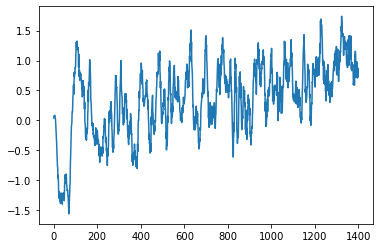

In [8]:
plt.plot(losses)
plt.show()

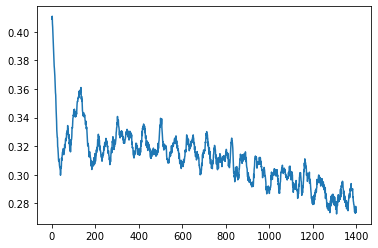

In [9]:
plt.plot(tranformed_privacies)
plt.show()

In [10]:
samples = model_ctgan.sample(len(data))  # Synthetic copy
samples.dropna(how='any', inplace=True)

X_syn = samples.drop(columns=[target])
y_syn = samples[target]
y_syn = y_syn.round(0)
y_syn = y_syn.astype(int)

## Privacy

In [11]:
samples = samples.apply(pd.to_numeric) # convert all columns of DataFrame
data = data.apply(pd.to_numeric) # convert all columns of DataFrame
samples = samples[:2000]
data = data[:2000]

In [12]:
normalized_avg_distance = normalized_avg_dist(samples, data)
print(normalized_avg_distance)

[0.14543781]


## Fidelity

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn, test_size=0.3, random_state=42)

rr_pred = []
fr_pred = []
ff_pred = []
rf_pred = []

rr_pred = get_predictions(X_train, y_train, X_test, y_test)
fr_pred = get_predictions(X_syn_train, y_syn_train, X_test, y_test)

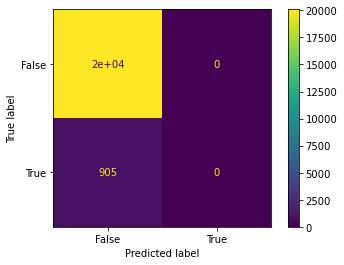

In [14]:
from sklearn import metrics
def print_confusion_matrix(rr_pred, fr_pred):
    confusion_matrix = metrics.confusion_matrix(rr_pred, fr_pred)

    cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display1.plot()
    plt.show()
    
print_confusion_matrix(rr_pred, fr_pred)

In [15]:
percentage, same_pred, dif_pred = eval_fidelity(rr_pred, fr_pred)

In [16]:
print(same_pred, dif_pred)

20095 905


## Final plot

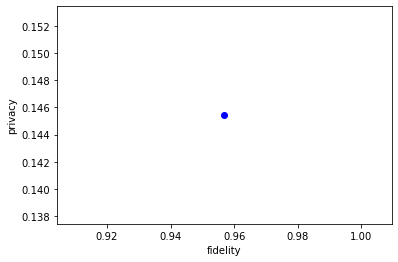

In [17]:
plt.scatter(percentage, normalized_avg_distance, c ="blue")
plt.xlabel("fidelity")
plt.ylabel("privacy")
plt.show()